In [278]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xgboost as xgb
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.stackedensemble import H2OStackedEnsembleEstimator
from h2o.grid.grid_search import H2OGridSearch
from __future__ import print_function
from h2o.estimators.xgboost import H2OXGBoostEstimator


In [279]:
import h2o


In [280]:
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator
from h2o.grid.grid_search import H2OGridSearch
import math
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.grid.grid_search import H2OGridSearch
from h2o.estimators.stackedensemble import H2OStackedEnsembleEstimator
h2o.init(nthreads=-1, strict_version_check=True)
h2o.init()
h2o.no_progress()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,5 hours 58 mins
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.20.0.1
H2O cluster version age:,12 days
H2O cluster name:,H2O_started_from_R_malaisi_fdj650
H2O cluster total nodes:,1
H2O cluster free memory:,990 Mb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"


Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,5 hours 58 mins
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.20.0.1
H2O cluster version age:,12 days
H2O cluster name:,H2O_started_from_R_malaisi_fdj650
H2O cluster total nodes:,1
H2O cluster free memory:,990 Mb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"


In [335]:
# Read data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000



## Data Pre-Processing
## #Impute any NaN Values

In [336]:
# Use H2O to create training and validation sets before data pre-processing
# Will now have three pandas data frames for test, training, and validation

h2otrain = h2o.H2OFrame(train)
h2otrain, h2ovalid = h2otrain.split_frame([0.7], seed=12345)
train = h2otrain.as_data_frame()
valid = h2ovalid.as_data_frame()

In [337]:
# Categorical Values

cat_train = train.select_dtypes(include=['object'])
cat_valid = valid.select_dtypes(include=['object'])
cat_test = test.select_dtypes(include=['object'])

In [338]:

# Numerical Values

num_train = train.select_dtypes(exclude=['object'])
num_valid = valid.select_dtypes(exclude=['object'])
num_test = test.select_dtypes(exclude=['object'])

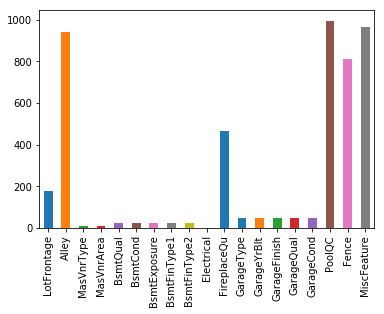

In [339]:
# Visualize Missing Values (both Numerical and Categorical)

trainmissing = train.isnull().sum()
trainmissing = trainmissing[trainmissing>0]

trainmissing
trainmissing.plot.bar()

In [340]:
# Numerical values I will impute NaN with the median (per professors code)
# Determine which columns have NaN

trcols = num_train.columns[num_train.isna().any()].tolist()
vacols = num_valid.columns[num_valid.isna().any()].tolist()
tecols = num_test.columns[num_test.isna().any()].tolist()

# Impute the median value for LotFrontage and GarageYrBlt

print('Training # Cols with NaN =', len(trcols))
print(trcols)
print()
print('Validation # Cols with NaN =', len(vacols))
print(vacols)
print()
print('Testing # Cols with NaN =', len(tecols))
print(tecols)

Training # Cols with NaN = 3
['LotFrontage', 'MasVnrArea', 'GarageYrBlt']

Validation # Cols with NaN = 3
['LotFrontage', 'MasVnrArea', 'GarageYrBlt']

Testing # Cols with NaN = 11
['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt', 'GarageCars', 'GarageArea']


In [341]:
# Lot Frontage: Linear feet of street connected to property# 

out1 = num_train['LotFrontage'].isna().sum()

print('Total Missing Values of LotFrontage in Training =', out1)

Total Missing Values of LotFrontage in Training = 179


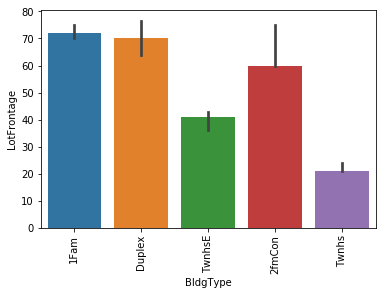

In [342]:

# This shows a bar plot of the median value per group with an error bar showing one standard deviation (to show variability)# 

sns.barplot(data=train,x='BldgType',y='LotFrontage', estimator=np.median)
plt.xticks(rotation=90)
plt.show()

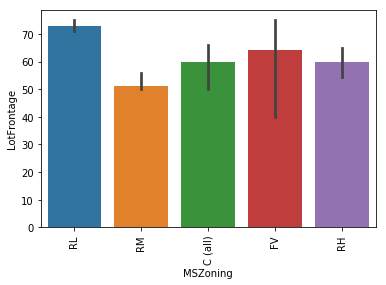

In [343]:
sns.barplot(data=train,x='MSZoning',y='LotFrontage', estimator=np.median)
plt.xticks(rotation=90)
plt.show()

In [344]:

# Assistance in creating this formula# Assista 
# https://stackoverflow.com/questions/19966018/pandas-filling-missing-values-by-mean-in-each-group

train['LotFrontage'] = train.groupby('BldgType')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
train['MasVnrArea'] = train.groupby('BldgType')['MasVnrArea'].transform(lambda x: x.fillna(x.median()))
train['GarageYrBlt'] = train.groupby('BldgType')['GarageYrBlt'].transform(lambda x: x.fillna(x.median()))
# Must also apply this to validation and testing data

valid['LotFrontage'] = valid.groupby('BldgType')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
valid['MasVnrArea'] = valid.groupby('BldgType')['MasVnrArea'].transform(lambda x: x.fillna(x.median()))
valid['GarageYrBlt'] = valid.groupby('BldgType')['GarageYrBlt'].transform(lambda x: x.fillna(x.median()))

test['LotFrontage'] = test.groupby('BldgType')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
test['MasVnrArea'] = test.groupby('BldgType')['MasVnrArea'].transform(lambda x: x.fillna(x.median()))
test['GarageYrBlt'] = test.groupby('BldgType')['GarageYrBlt'].transform(lambda x: x.fillna(x.median()))

In [345]:
train['LotFrontage']

0        65.0
1        80.0
2        68.0
3        84.0
4        85.0
5        75.0
6        51.0
7        70.0
8        85.0
9        72.0
10       91.0
11       72.0
12       72.0
13       70.0
14      101.0
15       75.0
16       44.0
17       72.0
18      110.0
19       60.0
20       98.0
21       47.0
22       50.0
23       85.0
24       70.0
25       60.0
26      108.0
27       68.0
28       65.0
29       84.0
        ...  
971      72.0
972      71.0
973      72.0
974      72.0
975      72.0
976      81.0
977      60.0
978      60.0
979      72.0
980      60.0
981      41.0
982      60.0
983      93.0
984      60.0
985      96.0
986      80.0
987      41.0
988      85.0
989      72.0
990      63.0
991      70.0
992      72.0
993      70.0
994      21.0
995      78.0
996      35.0
997      90.0
998      62.0
999      85.0
1000     75.0
Name: LotFrontage, Length: 1001, dtype: float64

In [346]:

# MasVnrArea: Masonry veneer area in square feet# MasVnrA 

out2 = num_train['MasVnrArea'].isna().sum()

print('Total Missing Values of MasVnrArea in Training =', out2)

Total Missing Values of MasVnrArea in Training = 7


In [347]:
# We can simply replace all missing values here with 0
# Note, we also must do this for our validation and test data

#train['MasVnrArea'] = train['MasVnrArea'].fillna(0)
#valid['MasVnrArea'] = valid['MasVnrArea'].fillna(0)
#test['MasVnrArea'] = test['MasVnrArea'].fillna(0)


In [348]:

# GarageYrBlt: Year garage was built# GarageY 
out3 = num_train['GarageYrBlt'].isna().sum()

print('Total Missing Values of GarageYrBlt in Training =', out3)

garg = train[num_train['GarageYrBlt'].isna()]
garg['GarageType']

# Similar to before, these values all have a missing garage type meaning there is no garage and we can impute with 0

Total Missing Values of GarageYrBlt in Training = 48


28     NaN
35     NaN
55     NaN
63     NaN
64     NaN
89     NaN
98     NaN
103    NaN
108    NaN
113    NaN
115    NaN
149    NaN
166    NaN
202    NaN
269    NaN
274    NaN
309    NaN
346    NaN
370    NaN
392    NaN
408    NaN
430    NaN
439    NaN
440    NaN
508    NaN
518    NaN
567    NaN
578    NaN
636    NaN
659    NaN
669    NaN
675    NaN
700    NaN
720    NaN
762    NaN
782    NaN
807    NaN
840    NaN
841    NaN
848    NaN
867    NaN
884    NaN
909    NaN
911    NaN
919    NaN
963    NaN
994    NaN
997    NaN
Name: GarageType, dtype: object

In [349]:


# We will do the same for Garage Cars and Garage Area that are missing in our test data set
# We cannot look at this data to determine if this is correct, but we must perform the actions based on our test data

train['GarageCars'] = train['GarageCars'].fillna(0)
valid['GarageCars'] = valid['GarageCars'].fillna(0)
test['GarageCars'] = test['GarageCars'].fillna(0)

train['GarageArea'] = train['GarageArea'].fillna(0)
valid['GarageArea'] = valid['GarageArea'].fillna(0)
test['GarageArea'] = test['GarageArea'].fillna(0)

In [350]:
# Finally, although there are no missing values in the test set for items related to the basement of a home
# our test data does have these issues. We will simply replace these missing values with zero assuming there is no
# basement at this location
# 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'

train['BsmtFinSF1'] = train['BsmtFinSF1'].fillna(0)
valid['BsmtFinSF1'] = valid['BsmtFinSF1'].fillna(0)
test['BsmtFinSF1'] = test['BsmtFinSF1'].fillna(0)

train['BsmtFinSF2'] = train['BsmtFinSF2'].fillna(0)
valid['BsmtFinSF2'] = valid['BsmtFinSF2'].fillna(0)
test['BsmtFinSF2'] = test['BsmtFinSF2'].fillna(0)

train['BsmtUnfSF'] = train['BsmtUnfSF'].fillna(0)
valid['BsmtUnfSF'] = valid['BsmtUnfSF'].fillna(0)
test['BsmtUnfSF'] = test['BsmtUnfSF'].fillna(0)

train['TotalBsmtSF'] = train['TotalBsmtSF'].fillna(0)
valid['TotalBsmtSF'] = valid['TotalBsmtSF'].fillna(0)
test['TotalBsmtSF'] = test['TotalBsmtSF'].fillna(0)

train['BsmtFullBath'] = train['BsmtFullBath'].fillna(0)
valid['BsmtFullBath'] = valid['BsmtFullBath'].fillna(0)
test['BsmtFullBath'] = test['BsmtFullBath'].fillna(0)

train['BsmtHalfBath'] = train['BsmtHalfBath'].fillna(0)
valid['BsmtHalfBath'] = valid['BsmtHalfBath'].fillna(0)
test['BsmtHalfBath'] = test['BsmtHalfBath'].fillna(0)

In [351]:
# Finally, we double check to make sure we have no more missing numerical values

num_train = train.select_dtypes(exclude=['object'])
num_valid = valid.select_dtypes(exclude=['object'])
num_test = test.select_dtypes(exclude=['object'])

trcols = num_train.columns[num_train.isna().any()].tolist()
vacols = num_valid.columns[num_valid.isna().any()].tolist()
tecols = num_test.columns[num_test.isna().any()].tolist()

print('Training # Cols with NaN =', len(trcols))
print(trcols)
print()
print('Validation # Cols with NaN =', len(vacols))
print(vacols)
print()
print('Testing # Cols with NaN =', len(tecols))
print(tecols)

Training # Cols with NaN = 0
[]

Validation # Cols with NaN = 0
[]

Testing # Cols with NaN = 0
[]


In [352]:
# Categorial values we will have to do case by case
# Start by determining which columns have NaN and what they should be replaced by
# For example: If no basement, all basement related will be NaN but they should say No Basement...

# Determine which columns have NaN

trcols = cat_train.columns[cat_train.isna().any()].tolist()
vacols = cat_valid.columns[cat_valid.isna().any()].tolist()
tecols = cat_test.columns[cat_test.isna().any()].tolist()

print('Training # Cols with NaN =', len(trcols))
print(trcols)
print()
print('Validation # Cols with NaN =', len(vacols))
print(vacols)
print()
print('Testing # Cols with NaN =', len(tecols))
print(tecols)

Training # Cols with NaN = 16
['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']

Validation # Cols with NaN = 15
['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']

Testing # Cols with NaN = 22
['MSZoning', 'Alley', 'Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType']


In [353]:
# Alley: Type of alley access to property where NA equals No Alley

train['Alley'] = train['Alley'].fillna('NoAlley')
valid['Alley'] = valid['Alley'].fillna('NoAlley')
test['Alley'] = test['Alley'].fillna('NoAlley')

In [354]:
# MasVnrType: Masonry veneer type where we will assume NA equals None

train['MasVnrType'] = train['MasVnrType'].fillna('None')
valid['MasVnrType'] = valid['MasVnrType'].fillna('None')
test['MasVnrType'] = test['MasVnrType'].fillna('None')

Total Missing Values of Utilities in Training = 0


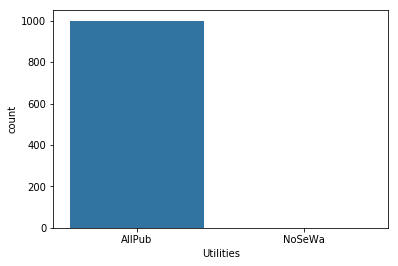

In [355]:
# Utilities: Type of utilities available
# There are no utility missing values in the training data, but we will replace this with all utilities available as
# all properties in the test set have all utilities available

out4 = cat_train['Utilities'].isna().sum()

print('Total Missing Values of Utilities in Training =', out4)

sns.countplot(x='Utilities', data=train)

In [356]:
train['Utilities'] = train['Utilities'].fillna('AllPub')
valid['Utilities'] = valid['Utilities'].fillna('AllPub')
test['Utilities'] = test['Utilities'].fillna('AllPub')

In [357]:
# Similar to our numerical data, we will assume all basement related missing values means there is no basement
# We confirm this below by looking at the numerical values about basements for those entries whose categorical basement values
# contains an NaN

out5 = cat_train['BsmtQual'].isna().sum()

print('Total Missing Values of Basement Quality in Training =', out5)

bsmt = train[cat_train['BsmtQual'].isna()]
bsmt['TotalBsmtSF']

Total Missing Values of Basement Quality in Training = 25


12     0
28     0
65     0
72     0
109    0
128    0
179    0
235    0
249    0
255    0
273    0
385    0
444    0
517    0
535    0
614    0
683    0
717    0
725    0
728    0
758    0
838    0
840    0
847    0
967    0
Name: TotalBsmtSF, dtype: int64

In [358]:
# NoBasement is confirmed and can be replaced in our set
# 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'

train['BsmtQual'] = train['BsmtQual'].fillna('NoBasement')
valid['BsmtQual'] = valid['BsmtQual'].fillna('NoBasement')
test['BsmtQual'] = test['BsmtQual'].fillna('NoBasement')

train['BsmtCond'] = train['BsmtCond'].fillna('NoBasement')
valid['BsmtCond'] = valid['BsmtCond'].fillna('NoBasement')
test['BsmtCond'] = test['BsmtCond'].fillna('NoBasement')

train['BsmtExposure'] = train['BsmtExposure'].fillna('NoBasement')
valid['BsmtExposure'] = valid['BsmtExposure'].fillna('NoBasement')
test['BsmtExposure'] = test['BsmtExposure'].fillna('NoBasement')

train['BsmtFinType1'] = train['BsmtFinType1'].fillna('NoBasement')
valid['BsmtFinType1'] = valid['BsmtFinType1'].fillna('NoBasement')
test['BsmtFinType1'] = test['BsmtFinType1'].fillna('NoBasement')

train['BsmtFinType2'] = train['BsmtFinType2'].fillna('NoBasement')
valid['BsmtFinType2'] = valid['BsmtFinType2'].fillna('NoBasement')
test['BsmtFinType2'] = test['BsmtFinType2'].fillna('NoBasement')

Total Missing Values of Electrical in Training = 1


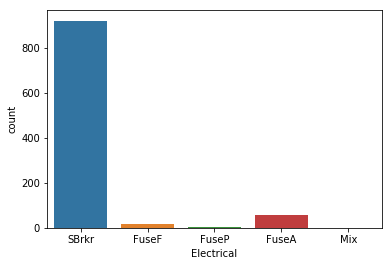

In [359]:

# Electrical: Electrical system# Electri 

out6 = cat_train['Electrical'].isna().sum()

print('Total Missing Values of Electrical in Training =', out6)

elec = train[cat_train['Electrical'].isna()]
elec

sns.countplot(x='Electrical', data=train)

In [360]:
# There is only one missing electrical value in the test data.
# We will impute this and all others with a standard configuration as this is the most common configuration

train['Electrical'] = train['Electrical'].fillna('SBrkr')
valid['Electrical'] = valid['Electrical'].fillna('SBrkr')
test['Electrical'] = test['Electrical'].fillna('SBrkr')

Total Missing Values of FireplaceQu in Training = 466


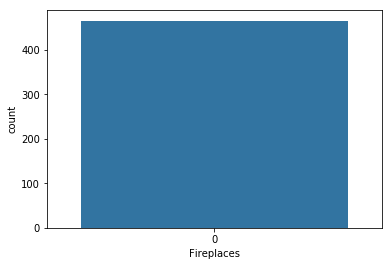

In [361]:
# 'FireplaceQu': Fireplace quality

out7 = cat_train['FireplaceQu'].isna().sum()

print('Total Missing Values of FireplaceQu in Training =', out7)

fire = train[cat_train['FireplaceQu'].isna()]

sns.countplot(x='Fireplaces', data=fire)

In [362]:
# As shown above, all missing fireplace quality values have 0 fireplaces

train['FireplaceQu'] = train['FireplaceQu'].fillna('NoFire')
valid['FireplaceQu'] = valid['FireplaceQu'].fillna('NoFire')
test['FireplaceQu'] = test['FireplaceQu'].fillna('NoFire')

Total Missing Values of PoolQC in Training = 995


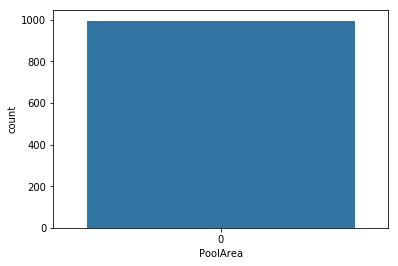

In [363]:
# 'PoolQC'

out8 = cat_train['PoolQC'].isna().sum()

print('Total Missing Values of PoolQC in Training =', out8)

pool = train[cat_train['PoolQC'].isna()]

sns.countplot(x='PoolArea', data=pool)

In [364]:
# As shown above, all missing pool quality values have 0 pools

train['PoolQC'] = train['PoolQC'].fillna('NoPool')
valid['PoolQC'] = valid['PoolQC'].fillna('NoPool')
test['PoolQC'] = test['PoolQC'].fillna('NoPool')

In [365]:
# 'Fence': Fence quality where NA equals no fence

train['Fence'] = train['Fence'].fillna('NoFence')
valid['Fence'] = valid['Fence'].fillna('NoFence')
test['Fence'] = test['Fence'].fillna('NoFence')

In [366]:
# 'MiscFeature': Miscellaneous feature not covered in other categories where NA equals None

train['MiscFeature'] = train['MiscFeature'].fillna('NoMisc')
valid['MiscFeature'] = valid['MiscFeature'].fillna('NoMisc')
test['MiscFeature'] = test['MiscFeature'].fillna('NoMisc')

In [367]:
# Similar to our numerical data, we will assume all garage related missing values means there is no garage
# We confirm this below by looking at the numerical values about garages for those entries whose categorical garage values
# contains an NaN

out9 = cat_train['GarageType'].isna().sum()

print('Total Missing Values of GarageType in Training =', out9)

gara = train[cat_train['GarageType'].isna()]
gara['GarageArea']

Total Missing Values of GarageType in Training = 48


28     0
35     0
55     0
63     0
64     0
89     0
98     0
103    0
108    0
113    0
115    0
149    0
166    0
202    0
269    0
274    0
309    0
346    0
370    0
392    0
408    0
430    0
439    0
440    0
508    0
518    0
567    0
578    0
636    0
659    0
669    0
675    0
700    0
720    0
762    0
782    0
807    0
840    0
841    0
848    0
867    0
884    0
909    0
911    0
919    0
963    0
994    0
997    0
Name: GarageArea, dtype: int64

In [368]:
# NoBasement is confirmed and can be replaced in our set
# 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'

train['GarageType'] = train['GarageType'].fillna('NoGarage')
valid['GarageType'] = valid['GarageType'].fillna('NoGarage')
test['GarageType'] = test['GarageType'].fillna('NoGarage')

train['GarageFinish'] = train['GarageFinish'].fillna('NoGarage')
valid['GarageFinish'] = valid['GarageFinish'].fillna('NoGarage')
test['GarageFinish'] = test['GarageFinish'].fillna('NoGarage')

train['GarageQual'] = train['GarageQual'].fillna('NoGarage')
valid['GarageQual'] = valid['GarageQual'].fillna('NoGarage')
test['GarageQual'] = test['GarageQual'].fillna('NoGarage')

train['GarageCond'] = train['GarageCond'].fillna('NoGarage')
valid['GarageCond'] = valid['GarageCond'].fillna('NoGarage')
test['GarageCond'] = test['GarageCond'].fillna('NoGarage')

In [369]:
# These features were not missing in the Training data but were missing in the Test Data
# 'MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'KitchenQual', 'Functional', 'SaleType'

# 'MSZoning', Utilities', 'Functional', 'KitchenQual' will replace with most frequent value

train['MSZoning'] = train['MSZoning'].transform(lambda x: x.fillna(x.value_counts().index[0]))
valid['MSZoning'] = valid['MSZoning'].transform(lambda x: x.fillna(x.value_counts().index[0]))
test['MSZoning'] = test['MSZoning'].transform(lambda x: x.fillna(x.value_counts().index[0]))

train['Utilities'] = train['Utilities'].transform(lambda x: x.fillna(x.value_counts().index[0]))
valid['Utilities'] = valid['Utilities'].transform(lambda x: x.fillna(x.value_counts().index[0]))
test['Utilities'] = test['Utilities'].transform(lambda x: x.fillna(x.value_counts().index[0]))

train['Functional'] = train['Functional'].transform(lambda x: x.fillna(x.value_counts().index[0]))
valid['Functional'] = valid['Functional'].transform(lambda x: x.fillna(x.value_counts().index[0]))
test['Functional'] = test['Functional'].transform(lambda x: x.fillna(x.value_counts().index[0]))

train['KitchenQual'] = train['KitchenQual'].transform(lambda x: x.fillna(x.value_counts().index[0]))
valid['KitchenQual'] = valid['KitchenQual'].transform(lambda x: x.fillna(x.value_counts().index[0]))
test['KitchenQual'] = test['KitchenQual'].transform(lambda x: x.fillna(x.value_counts().index[0]))

# 'Exterior1st', 'Exterior2nd', 'SaleType' will replace with Other

train['Exterior1st'] = train['Exterior1st'].fillna('Other')
valid['Exterior1st'] = valid['Exterior1st'].fillna('Other')
test['Exterior1st'] = test['Exterior1st'].fillna('Other')

train['Exterior2nd'] = train['Exterior2nd'].fillna('Other')
valid['Exterior2nd'] = valid['Exterior2nd'].fillna('Other')
test['Exterior2nd'] = test['Exterior2nd'].fillna('Other')

train['SaleType'] = train['SaleType'].fillna('Other')
valid['SaleType'] = valid['SaleType'].fillna('Other')
test['SaleType'] = test['SaleType'].fillna('Other')

In [370]:
# Confirm I have removed all NaNs

trcols = train.columns[train.isna().any()].tolist()
vacols = valid.columns[valid.isna().any()].tolist()
tecols = test.columns[test.isna().any()].tolist()

print('Training # Cols with NaN =', len(trcols))
print(trcols)
print()
print('Validation # Cols with NaN =', len(vacols))
print(vacols)
print()
print('Testing # Cols with NaN =', len(tecols))
print(tecols)

Training # Cols with NaN = 0
[]

Validation # Cols with NaN = 0
[]

Testing # Cols with NaN = 0
[]


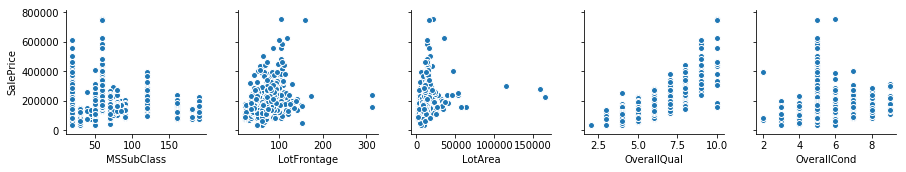

In [371]:
# Start by graphing all of the numerical values
# Remove outliers based on housing price

sns.pairplot(data=train,
                  y_vars=['SalePrice'],
                  x_vars=['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond'])

In [372]:
#we should use lotfrontage, lotarea's log to do the regression

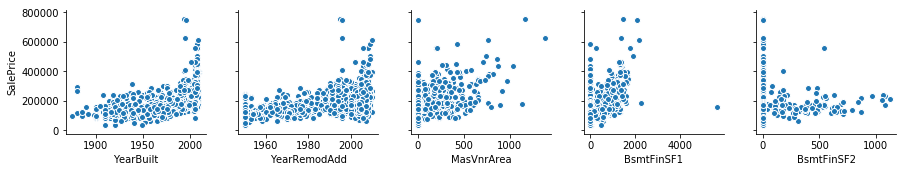

In [373]:
sns.pairplot(data=train,
                  y_vars=['SalePrice'],
                  x_vars=['YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2'])

In [374]:
# we should  do the log transform to the MasVnrArea.


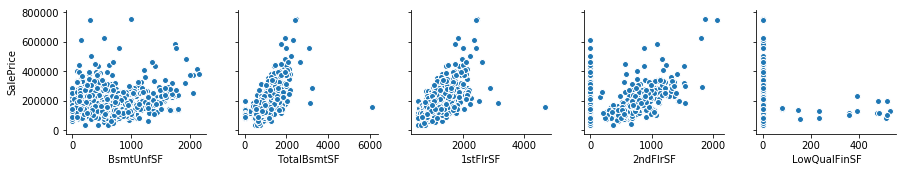

In [375]:
sns.pairplot(data=train,
                  y_vars=['SalePrice'],
                  x_vars=['BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF'])

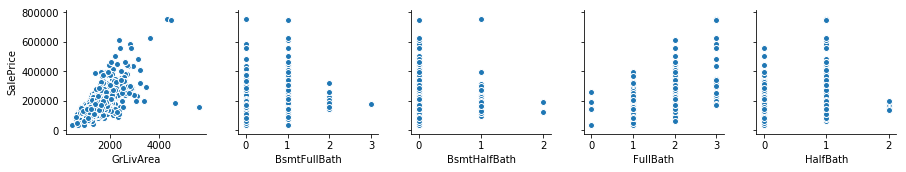

In [376]:
sns.pairplot(data=train,
                  y_vars=['SalePrice'],
                  x_vars=['GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath'])

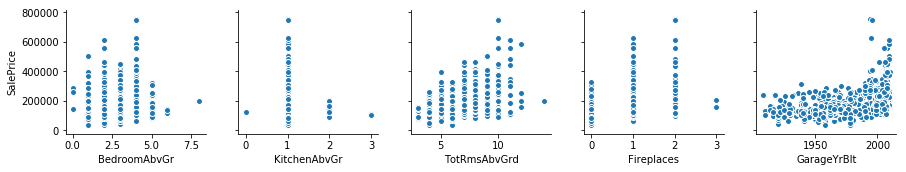

In [377]:
sns.pairplot(data=train,
                  y_vars=['SalePrice'],
                  x_vars=['BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt'])

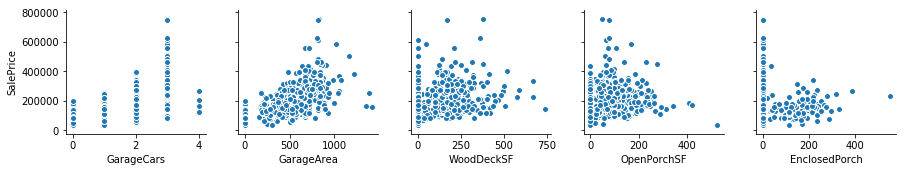

In [378]:
sns.pairplot(data=train,
                  y_vars=['SalePrice'],
                  x_vars=['GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch'])

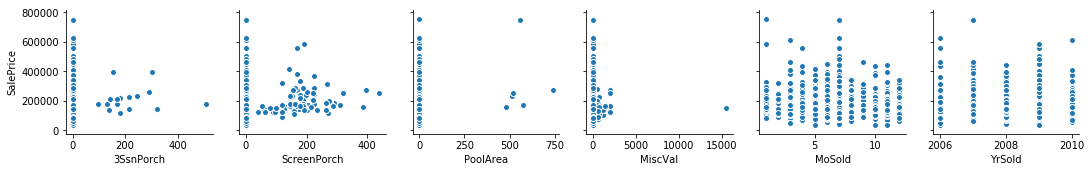

In [379]:
sns.pairplot(data=train,
                  y_vars=['SalePrice'],
                  x_vars=['3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold'])

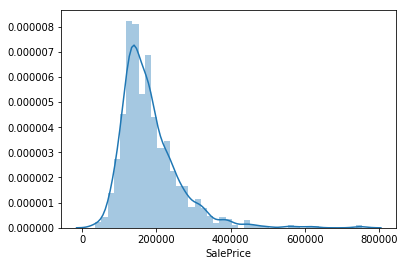

In [380]:
sns.distplot(train['SalePrice'])

In [381]:
train = train.drop(train[(train['LotFrontage']>300) |
                         (train['LotArea']>100000) |
                         (train['BsmtFinSF1']>4000) |
                         (train['TotalBsmtSF']>4000) |
                         (train['1stFlrSF']>4000) |
                         (train['GrLivArea']>4600) |
                         (train['3SsnPorch']>400) |
                         (train['MiscVal']>10000)].index)

valid = valid.drop(valid[(valid['LotFrontage']>300) |
                         (valid['LotArea']>100000) |
                         (valid['BsmtFinSF1']>4000) |
                         (valid['TotalBsmtSF']>4000) |
                         (valid['1stFlrSF']>4000) |
                         (valid['GrLivArea']>4600) |
                         (valid['3SsnPorch']>400) |
                         (valid['MiscVal']>10000)].index)

In [382]:

# Apply log transform# Apply l 
train["SalePrice"] = np.log(train["SalePrice"]+0.001)
train["LotFrontage"] = np.log(train["LotFrontage"]+0.001)
train["LotArea"] = np.log(train["LotArea"]+0.001)
train["MasVnrArea"] = np.log(train["MasVnrArea"]+0.001)
train["BsmtUnfSF"] = np.log(train["BsmtUnfSF"]+0.001)
train["1stFlrSF"] = np.log(train["1stFlrSF"]+0.001)
train["2ndFlrSF"] = np.log(train["2ndFlrSF"]+0.001)
train["GrLivArea"] = np.log(train["GrLivArea"]+0.001)
train["GarageArea"] = np.log(train["GarageArea"]+0.001)
train["WoodDeckSF"] = np.log(train["WoodDeckSF"]+0.001)
train["OpenPorchSF"] = np.log(train["OpenPorchSF"]+0.001)
train["OpenPorchSF"] = np.log(train["ScreenPorch"]+0.001)


test["LotFrontage"] = np.log(test["LotFrontage"]+0.001)
test["LotArea"] = np.log(test["LotArea"]+0.001)
test["MasVnrArea"] = np.log(test["MasVnrArea"]+0.001)
test["BsmtUnfSF"] = np.log(test["BsmtUnfSF"]+0.001)
test["1stFlrSF"] = np.log(test["1stFlrSF"]+0.001)
test["2ndFlrSF"] = np.log(test["2ndFlrSF"]+0.001)
test["GrLivArea"] = np.log(test["GrLivArea"]+0.001)
test["GarageArea"] = np.log(test["GarageArea"]+0.001)
test["WoodDeckSF"] = np.log(test["WoodDeckSF"]+0.001)
test["OpenPorchSF"] = np.log(test["OpenPorchSF"]+0.001)
test["OpenPorchSF"] = np.log(test["ScreenPorch"]+0.001)



valid["LotFrontage"] = np.log(valid["LotFrontage"]+0.001)
valid["SalePrice"] = np.log(valid["SalePrice"]+0.001)
valid["LotArea"] = np.log(valid["LotArea"]+0.001)
valid["MasVnrArea"] = np.log(valid["MasVnrArea"]+0.001)
valid["BsmtUnfSF"] = np.log(valid["BsmtUnfSF"]+0.001)
valid["1stFlrSF"] = np.log(valid["1stFlrSF"]+0.001)
valid["2ndFlrSF"] = np.log(valid["2ndFlrSF"]+0.001)
valid["GrLivArea"] = np.log(valid["GrLivArea"]+0.001)
valid["GarageArea"] = np.log(valid["GarageArea"]+0.001)
valid["WoodDeckSF"] = np.log(valid["WoodDeckSF"]+0.001)
valid["OpenPorchSF"] = np.log(valid["OpenPorchSF"]+0.001)
valid["OpenPorchSF"] = np.log(valid["ScreenPorch"]+0.001)

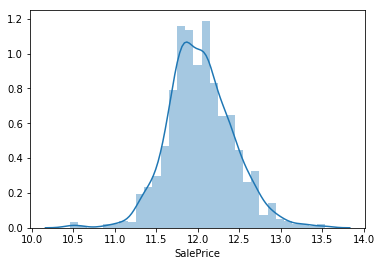

In [383]:
sns.distplot(train['SalePrice'])

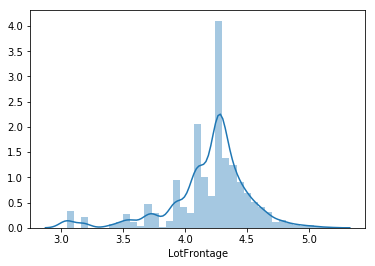

In [384]:
sns.distplot(train['LotFrontage'])

In [385]:
#sns.pairplot(data=train,
                 # y_vars=['SalePrice'],
                 # x_vars=['LotFrontage', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF'])

In [386]:
# Need to re-initialize my categorical dataframes with updated / imputed information

cat_train = train.select_dtypes(include=['object'])
cat_valid = valid.select_dtypes(include=['object'])
cat_test = test.select_dtypes(include=['object'])

In [387]:
# Taken directly from professor's code

# one-hot encode training frame
train_cats_df = cat_train
train_cats_df_dummies = pd.get_dummies(train_cats_df)

# one-hot encode validation frame
valid_cats_df = cat_valid
valid_cats_df_dummies = pd.get_dummies(valid_cats_df)

# keep only the same new columns in the encoded new frames
# (they different b/c of different levels in variables)
train_diff_cols = list(set(train_cats_df_dummies.columns) - set(valid_cats_df_dummies.columns))
valid_diff_cols = list(set(valid_cats_df_dummies.columns) - set(train_cats_df_dummies.columns))
train_cats_df_dummies.drop(train_diff_cols, axis=1, inplace=True)
valid_cats_df_dummies.drop(valid_diff_cols, axis=1, inplace=True)

# check that columns are actually the same in both frames
print(train_cats_df_dummies.shape)
print(valid_cats_df_dummies.shape)
print(all(train_cats_df_dummies.columns == valid_cats_df_dummies.columns))

# one-hot encode test frame
test_cats_df = cat_test
test_cats_df_dummies = pd.get_dummies(test_cats_df)

# keep only the same new columns in train and valid encoded frames
# (they different b/c of different levels in variables)
# remove columns in train and valid encoded frames not in encoded test frame
# remember encoded train and valid now have same columns
# so only need to check for train OR valid, not both
train_diff_cols = list(set(train_cats_df_dummies.columns) - set(test_cats_df_dummies.columns))
train_cats_df_dummies.drop(train_diff_cols, axis=1, inplace=True)
valid_cats_df_dummies.drop(train_diff_cols, axis=1, inplace=True)

# check that columns are actually the same in encoded train and valid frames
print(train_cats_df_dummies.shape)
print(valid_cats_df_dummies.shape)
print(all(train_cats_df_dummies.columns == valid_cats_df_dummies.columns))

# now remove columns in encoded test not in encoded train and valid
# (they different b/c of different levels in variables)
train_diff_cols = list(set(test_cats_df_dummies.columns) - set(train_cats_df_dummies.columns))
test_cats_df_dummies.drop(train_diff_cols, axis=1, inplace=True)

# check that columns are actually the same in all encoded frames
print(train_cats_df_dummies.shape)
print(valid_cats_df_dummies.shape)
print(test_cats_df_dummies.shape)
print(all(train_cats_df_dummies.columns == valid_cats_df_dummies.columns) and all(valid_cats_df_dummies.columns == test_cats_df_dummies.columns))

# convert to h2o
train_one_hot = h2o.H2OFrame(train_cats_df_dummies.as_matrix())
train_one_hot.columns = list(train_cats_df_dummies.columns)
train = h2o.H2OFrame(train)
train = train.cbind(train_one_hot)

valid_one_hot = h2o.H2OFrame(valid_cats_df_dummies.as_matrix())
valid_one_hot.columns = list(valid_cats_df_dummies.columns)
valid = h2o.H2OFrame(valid)
valid = valid.cbind(valid_one_hot)

test_one_hot = h2o.H2OFrame(test_cats_df_dummies.as_matrix())
test_one_hot.columns = list(test_cats_df_dummies.columns)
test = h2o.H2OFrame(test)
test = test.cbind(test_one_hot)

(993, 229)
(457, 229)
True
(993, 224)
(457, 224)
True
(993, 224)
(457, 224)
(1459, 224)
True


# Generalized Linear Regression Method

In [388]:
def  glm_grid(X, y, train, valid):
    
    """ Wrapper function for penalized GLM with alpha and lambda search.
    
    :param X: List of inputs.
    :param y: Name of target variable.
    :param train: Name of training H2OFrame.
    :param valid: Name of validation H2OFrame.
    :return: Best H2Omodel from H2OGeneralizedLinearEstimator

    """
    
    alpha_opts = [0.01, 0.25, 0.5, 0.99] # always keep some L2
    hyper_parameters = {'alpha': alpha_opts}

    # initialize grid search
    grid = H2OGridSearch(
        H2OGeneralizedLinearEstimator(
            family="gaussian",
            lambda_search=True,
            seed=12345),
        hyper_params=hyper_parameters)
    
    # train grid
    grid.train(y=y,
               x=X, 
               training_frame=train,
               validation_frame=valid)

    # show grid search results
    print(grid.show())

    best = grid.get_grid()[0]
    print(best)
    
    # plot top frame values
    yhat_frame = valid.cbind(best.predict(valid))
    print(yhat_frame[0:10, [y, 'predict']])

    # plot sorted predictions
    yhat_frame_df = yhat_frame[[y, 'predict']].as_data_frame()
    yhat_frame_df.sort_values(by='predict', inplace=True)
    yhat_frame_df.reset_index(inplace=True, drop=True)
    _ = yhat_frame_df.plot(title='Ranked Predictions Plot')
    
    # select best model
    return best

In [389]:
h2o.show_progress()
colselect = h2otrain.as_data_frame()
glm_cols = colselect.columns.tolist()

glm Grid Build progress: |████████████████████████████████████████████████| 100%
      alpha                                                       model_ids  \
0    [0.99]  Grid_GLM_py_167_sid_811e_model_python_1529446872170_53_model_3   
1     [0.5]  Grid_GLM_py_167_sid_811e_model_python_1529446872170_53_model_2   
2    [0.25]  Grid_GLM_py_167_sid_811e_model_python_1529446872170_53_model_1   
3    [0.01]  Grid_GLM_py_167_sid_811e_model_python_1529446872170_53_model_0   

   residual_deviance  
0  5.670988341893677  
1  5.677106749600544  
2  5.690707135947299  
3  6.426496243126385  
None
Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_py_167_sid_811e_model_python_1529446872170_53_model_3


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.014007726253175626
RMSE: 0.1183542405373615
MAE: 0.08326793519807507
RMSLE: 0.00924657336035136
R^2: 0.9098964268164106
Mean Residual Deviance: 0.014007726253175626
Null degrees of f

,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_test
,2018-06-20 00:22:03,0.000 sec,1,.32E0,1,0.1554625,0.1684591
,2018-06-20 00:22:03,0.002 sec,2,.31E0,2,0.1463011,0.1579085
,2018-06-20 00:22:03,0.003 sec,3,.3E0,2,0.1379501,0.1482940
,2018-06-20 00:22:03,0.005 sec,4,.28E0,2,0.1303377,0.1395330
,2018-06-20 00:22:03,0.007 sec,5,.27E0,2,0.1233989,0.1315500
---,---,---,---,---,---,---,---
,2018-06-20 00:22:04,0.199 sec,96,.39E-2,33,0.0146515,0.0128301
,2018-06-20 00:22:04,0.202 sec,97,.37E-2,36,0.0145169,0.0127488
,2018-06-20 00:22:04,0.205 sec,98,.36E-2,40,0.0143503,0.0126410
,2018-06-20 00:22:04,0.206 sec,99,.34E-2,42,0.0141728,0.0125314



See the whole table with table.as_data_frame()

glm prediction progress: |████████████████████████████████████████████████| 100%


/Users/malaisi/anaconda3/lib/python3.6/site-packages/h2o/job.py:69: UserWarning: Test/Validation dataset column 'Exterior2nd' has levels not trained on: [CBlock]
  warnings.warn(w)
/Users/malaisi/anaconda3/lib/python3.6/site-packages/h2o/job.py:69: UserWarning: Test/Validation dataset column 'Exterior1st' has levels not trained on: [AsphShn, CBlock]
  warnings.warn(w)
/Users/malaisi/anaconda3/lib/python3.6/site-packages/h2o/job.py:69: UserWarning: Test/Validation dataset column 'Condition1' has levels not trained on: [RRNe]
  warnings.warn(w)
/Users/malaisi/anaconda3/lib/python3.6/site-packages/h2o/job.py:69: UserWarning: Test/Validation dataset column 'Condition2' has levels not trained on: [PosA, RRAe]
  warnings.warn(w)
/Users/malaisi/anaconda3/lib/python3.6/site-packages/h2o/job.py:69: UserWarning: Test/Validation dataset column 'Heating' has levels not trained on: [Floor]
  warnings.warn(w)
/Users/malaisi/anaconda3/lib/python3.6/site-packages/h2o/job.py:69: UserWarning: Test/Valid

SalePrice,predict
11.8494,11.9655
12.2061,12.3728
11.6784,11.6743
11.7906,11.7892
11.9117,11.9773
11.9767,11.9515
11.8451,11.792
11.1346,11.1007
11.914,11.7933
11.8845,11.8824


AttributeError: type object 'H2OGeneralizedLinearEstimator' has no attribute 'exp'

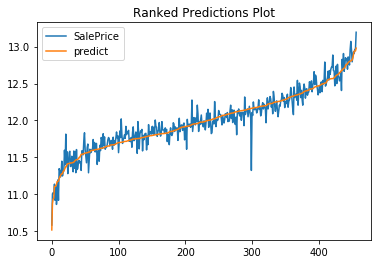

In [390]:
glm_0 = glm_grid(glm_cols, 'SalePrice', train, valid)
gen_submission(glm_0)

# Create submission method

In [391]:
def ranked_preds_plot(y, valid, preds):
    
    """ Generates ranked prediction plot.
    
    :param y: Name of target variable.
    :param valid: Name of validation H2OFrame.
    :param preds: Column vector of predictions to plot.

    """
    
    # plot top frame values
    preds.columns = ['predict']
    yhat_frame = valid.cbind(preds)
    print(yhat_frame[0:10, [y, 'predict']])

    # plot sorted predictions
    yhat_frame_df = yhat_frame[[y, 'predict']].as_data_frame()
    yhat_frame_df.sort_values(by='predict', inplace=True)
    yhat_frame_df.reset_index(inplace=True, drop=True)
    _ = yhat_frame_df.plot(title='Ranked Predictions Plot')

In [392]:

import re
import time

def  gen_submission(preds, test=test):

    """ Generates submission file for Kaggle House Prices contest.
    
    :param preds: Column vector of predictions.
    :param test: Test data.
    
    """
    
    # create time stamp
    time_stamp = re.sub('[: ]', '_', time.asctime())

    # create predictions column
    sub = test['Id'].cbind(preds.exp())
    sub.columns = ['Id', 'SalePrice']
    
    # save file for submission
    sub_fname =  str(time_stamp) + '.csv'
    h2o.download_csv(sub, sub_fname)

# Gradient Boosting Method




###   0.12605 on kaggle public leaderboard

In [393]:
def get_type_lists(frame=train, rejects=['Id', 'SalePrice']):

    """Creates lists of numeric and categorical variables.
    
    :param frame: The frame from which to determine types.
    :param rejects: Variable names not to be included in returned lists.
    :return: Tuple of lists for numeric and categorical variables in the frame.
    
    """
    
    nums, cats = [], []
    for key, val in frame.types.items():
        if key not in rejects:
            if val == 'enum':
                cats.append(key)
            else: 
                nums.append(key)
                
    print('Numeric =', nums)                
    print()
    print('Categorical =', cats)
    
    return nums, cats

In [394]:
 encoded_combined_nums, cats = get_type_lists(frame=train)

Numeric = ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM', 'Street_Grvl', 'Street_Pave', 'Alley_Grvl', 'Alley_NoAlley', 'Alley_Pave', 'LotShape_IR1', 'LotShape_IR2', 'LotShape_IR3', 'LotShape_Reg', 'LandContour_Bnk', 'LandContour_HLS', 'LandContour_Low', 'LandContour_Lvl', 'Utilities_AllPub', 'LotConfig_Corner', 'LotConfig_CulDSac', 'LotConfig_FR2', 'LotConfig_Inside', 'LandSlope_Gtl', 'LandSlope_Mod', 'LandSlope_Sev', 'Neighborhood_Blmngtn', 'Neighborhood_BrDale'

In [395]:
# initialize H2O GBM
h2o_gbm_model = H2OGradientBoostingEstimator(
    ntrees = 10000,
    learn_rate = 0.005,
    sample_rate = 0.1, 
    col_sample_rate = 0.8,
    max_depth = 5,
    nfolds = 3,
    keep_cross_validation_predictions=True,
    stopping_rounds = 10,
    seed = 12345)

# execute training
h2o_gbm_model.train(x=encoded_combined_nums,
                    y='SalePrice',
                    training_frame=train,
                    validation_frame=valid)

# print model information/create submission
print(h2o_gbm_model)
h2o_gbm_preds1_val = h2o_gbm_model.predict(valid)

gbm Model Build progress: |███████████████████████████████████████████████| 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1529446872170_54


ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.004791714672507485
RMSE: 0.0692222122768948
MAE: 0.04578679613956632
RMSLE: 0.0054433371814821925
Mean Residual Deviance: 0.004791714672507485

ModelMetricsRegression: gbm
** Reported on validation data. **

MSE: 0.012815405837963532
RMSE: 0.11320514934385066
MAE: 0.07944141495906205
RMSLE: 0.008822508269347001
Mean Residual Deviance: 0.012815405837963532

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 0.016174081700245743
RMSE: 0.12717736315966668
MAE: 0.08947267784907814
RMSLE: 0.009896636627041338
Mean Residual Deviance: 0.016174081700245743
Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid
mae,0.0893898,0.0013274,0.0874851,0.0919438,0.0887404
mean_residual_deviance,0.0161095,0.0010655,0.0144163,0.0180767,0.0158356
mse,0.0161095,0.0010655,0.0144163,0.0180767,0.0158356
r2,0.8962302,0.0055554,0.9052109,0.8860744,0.8974055
residual_deviance,0.0161095,0.0010655,0.0144163,0.0180767,0.0158356
rmse,0.1267857,0.0041785,0.1200678,0.1344496,0.1258397
rmsle,0.0098593,0.0003821,0.0092111,0.0105341,0.0098328


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2018-06-20 00:26:48,4 min 5.366 sec,0.0,0.3942873,0.3051797,0.1554625,0.4104377,0.3211808,0.1684591
,2018-06-20 00:26:48,4 min 5.392 sec,1.0,0.3929554,0.3040675,0.1544140,0.4091695,0.3200583,0.1674196
,2018-06-20 00:26:48,4 min 5.404 sec,2.0,0.3917729,0.3030193,0.1534860,0.4080080,0.3190120,0.1664705
,2018-06-20 00:26:48,4 min 5.415 sec,3.0,0.3903051,0.3018147,0.1523381,0.4063849,0.3176892,0.1651487
,2018-06-20 00:26:48,4 min 5.427 sec,4.0,0.3888581,0.3005611,0.1512106,0.4048453,0.3163981,0.1638997
---,---,---,---,---,---,---,---,---,---
,2018-06-20 00:28:05,5 min 21.533 sec,7255.0,0.0723807,0.0480387,0.0052390,0.1130811,0.0791079,0.0127873
,2018-06-20 00:28:09,5 min 25.542 sec,7578.0,0.0713227,0.0474650,0.0050869,0.1130508,0.0791779,0.0127805
,2018-06-20 00:28:13,5 min 29.545 sec,7904.0,0.0702495,0.0466735,0.0049350,0.1130809,0.0790901,0.0127873
,2018-06-20 00:28:17,5 min 33.546 sec,8184.0,0.0693996,0.0459576,0.0048163,0.1131640,0.0793768,0.0128061



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
OverallQual,6001.7246094,1.0,0.5699766
YearBuilt,915.7544556,0.1525819,0.0869681
GrLivArea,749.0723877,0.1248095,0.0711385
TotalBsmtSF,256.4638977,0.0427317,0.0243561
ExterQual_TA,208.4062958,0.0347244,0.0197921
---,---,---,---
SaleType_ConLI,0.0,0.0,0.0
SaleType_ConLw,0.0,0.0,0.0
SaleType_Oth,0.0,0.0,0.0
SaleCondition_Alloca,0.0,0.0,0.0



See the whole table with table.as_data_frame()

gbm prediction progress: |████████████████████████████████████████████████| 100%


gbm prediction progress: |████████████████████████████████████████████████| 100%


SalePrice,predict
11.8494,12.0347
12.2061,12.2518
11.6784,11.8015
11.7906,11.8338
11.9117,11.9099
11.9767,11.9584
11.8451,11.7407
11.1346,11.1699
11.914,11.8018
11.8845,11.916



gbm prediction progress: |████████████████████████████████████████████████| 100%


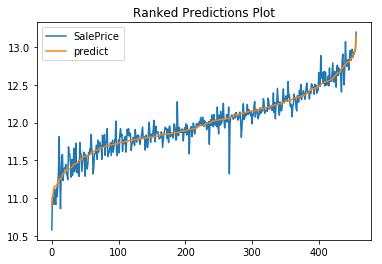

In [396]:
h2o_gbm_preds1_val = h2o_gbm_model.predict(valid)
ranked_preds_plot('SalePrice', valid, h2o_gbm_preds1_val) # better validation error
h2o_gbm_preds1_test = h2o_gbm_model.predict(test)
gen_submission(h2o_gbm_preds1_test) # 0.12605 on kaggle public leaderboard

# XGBoost Method


### 0.13302 on kaggle public leaderboard

xgboost Model Build progress: |███████████████████████████████████████████| 100%
Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_model_python_1529446872170_55


ModelMetricsRegression: xgboost
** Reported on train data. **

MSE: 0.0007437527089979375
RMSE: 0.027271829953230815
MAE: 0.022736370743581535
RMSLE: 0.0021046307252640182
Mean Residual Deviance: 0.0007437527089979375

ModelMetricsRegression: xgboost
** Reported on validation data. **

MSE: 0.012659142183212313
RMSE: 0.11251285341334258
MAE: 0.0789222237317776
RMSLE: 0.008747082816549448
Mean Residual Deviance: 0.012659142183212313

ModelMetricsRegression: xgboost
** Reported on cross-validation data. **

MSE: 0.015457667394561486
RMSE: 0.12432886790509068
MAE: 0.08621185663843683
RMSLE: 0.009687736776600708
Mean Residual Deviance: 0.015457667394561486
Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid
mae,0.0409686,0.0005477,0.0398741,0.0414775,0.0415541
mean_residual_deviance,0.0054771,0.0004690,0.0045406,0.0059907,0.0059000
mse,0.0054771,0.0004690,0.0045406,0.0059907,0.0059000
r2,0.9647688,0.0030166,0.9707927,0.961465,0.9620488
residual_deviance,0.0054771,0.0004690,0.0045406,0.0059907,0.0059000
rmse,0.0738652,0.0032449,0.0673843,0.0773999,0.0768114
rmsle,0.0057496,0.0002884,0.0051727,0.0060393,0.0060367


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2018-06-20 00:34:02,1 min 27.995 sec,0.0,11.5374569,11.5307177,133.1129127,11.5108852,11.5035975,132.5004787
,2018-06-20 00:34:02,1 min 28.058 sec,1.0,11.4799204,11.4731952,131.7885716,11.4535062,11.4462290,131.1828036
,2018-06-20 00:34:02,1 min 28.087 sec,2.0,11.4224819,11.4157766,130.4730924,11.3963145,11.3890507,129.8759835
,2018-06-20 00:34:02,1 min 28.116 sec,3.0,11.3654383,11.3587466,129.1731869,11.3393832,11.3321329,128.5816115
,2018-06-20 00:34:02,1 min 28.144 sec,4.0,11.3087564,11.3020781,127.8879720,11.2829140,11.2756748,127.3041494
---,---,---,---,---,---,---,---,---,---
,2018-06-20 00:34:22,1 min 48.003 sec,3950.0,0.0570164,0.0455525,0.0032509,0.1142294,0.0796561,0.0130483
,2018-06-20 00:34:26,1 min 52.617 sec,4975.0,0.0502116,0.0407370,0.0025212,0.1138470,0.0793695,0.0129611
,2018-06-20 00:34:33,1 min 58.801 sec,6268.0,0.0429344,0.0351372,0.0018434,0.1132911,0.0792942,0.0128349
,2018-06-20 00:34:44,2 min 10.223 sec,8449.0,0.0328096,0.0271970,0.0010765,0.1126562,0.0788187,0.0126914



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
MSSubClass,26229.0,1.0,0.1568401
LotFrontage,22622.0,0.8624805,0.1352715
LotArea,14353.0,0.5472187,0.0858258
BsmtUnfSF,6968.0,0.2656601,0.0416662
YearBuilt,6687.0,0.2549468,0.0399859
---,---,---,---
BsmtFinType2_GLQ,1.0,0.0000381,0.0000060
HouseStyle_2.5Unf,1.0,0.0000381,0.0000060
SaleType_Oth,1.0,0.0000381,0.0000060
Street_Pave,1.0,0.0000381,0.0000060



See the whole table with table.as_data_frame()

xgboost prediction progress: |████████████████████████████████████████████| 100%


SalePrice,predict
11.8494,12.0595
12.2061,12.2606
11.6784,11.7082
11.7906,11.8027
11.9117,11.9304
11.9767,11.9013
11.8451,11.8268
11.1346,11.1102
11.914,11.8053
11.8845,11.921



xgboost prediction progress: |████████████████████████████████████████████| 100%


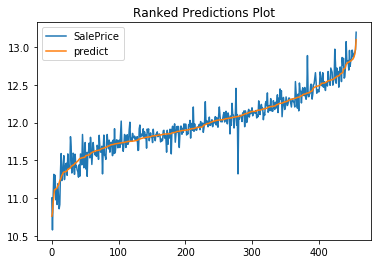

In [397]:

# initialize XGB GBM# initial 
h2o_xgb_model = H2OXGBoostEstimator(
    ntrees = 10000,
    learn_rate = 0.005,
    sample_rate = 0.1, 
    col_sample_rate = 0.8,
    max_depth = 5,
    nfolds = 3,
    keep_cross_validation_predictions=True,
    stopping_rounds = 10,
    seed = 12345)

# execute training 
h2o_xgb_model.train(x=encoded_combined_nums,
                    y='SalePrice',
                    training_frame=train,
                    validation_frame=valid)

# print model information/create submission
print(h2o_xgb_model)
h2o_xgb_preds1_val = h2o_xgb_model.predict(valid)
ranked_preds_plot('SalePrice', valid, h2o_xgb_preds1_val) 
h2o_xgb_preds1_test = h2o_xgb_model.predict(test)
gen_submission(h2o_xgb_preds1_test) # 0.13302 on public leaderboard



# Random Forest Method


### 0.18030 on kaggle public leaderboard

drf Model Build progress: |███████████████████████████████████████████████| 100%
Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1529446872170_42


ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.03068667953307706
RMSE: 0.17517613859506398
MAE: 0.12124603270371571
RMSLE: 0.013589864288729912
Mean Residual Deviance: 0.03068667953307706

ModelMetricsRegression: drf
** Reported on validation data. **

MSE: 0.032724475631098454
RMSE: 0.18089907581604295
MAE: 0.12134822041970224
RMSLE: 0.014031435775870904
Mean Residual Deviance: 0.032724475631098454

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 0.03010530908487232
RMSE: 0.17350881558258738
MAE: 0.12067783028777351
RMSLE: 0.013461578185876509
Mean Residual Deviance: 0.03010530908487232
Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid
mae,0.1198473,0.0095206,0.1013477,0.1330024,0.1251917
mean_residual_deviance,0.0296513,0.0048680,0.0214815,0.0383225,0.0291499
mse,0.0296513,0.0048680,0.0214815,0.0383225,0.0291499
r2,0.7993931,0.0207353,0.8216038,0.7579583,0.8186170
residual_deviance,0.0296513,0.0048680,0.0214815,0.0383225,0.0291499
rmse,0.1710202,0.0142022,0.1465658,0.1957613,0.1707334
rmsle,0.0132365,0.0012199,0.0111730,0.0153958,0.0131407


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2018-06-20 00:02:27,6.461 sec,0.0,nan,nan,nan,nan,nan,nan
,2018-06-20 00:02:27,6.489 sec,1.0,0.2982085,0.2143869,0.0889283,0.2785673,0.2083989,0.0775998
,2018-06-20 00:02:27,6.509 sec,2.0,0.2815257,0.2061073,0.0792567,0.2345454,0.1728350,0.0550116
,2018-06-20 00:02:27,6.535 sec,3.0,0.2507953,0.1812934,0.0628983,0.2135880,0.1510122,0.0456198
,2018-06-20 00:02:27,6.549 sec,4.0,0.2733915,0.1948739,0.0747429,0.2203927,0.1582655,0.0485730
---,---,---,---,---,---,---,---,---,---
,2018-06-20 00:02:31,10.616 sec,155.0,0.1753803,0.1212734,0.0307582,0.1810472,0.1216389,0.0327781
,2018-06-20 00:02:31,10.660 sec,156.0,0.1753162,0.1212643,0.0307358,0.1809627,0.1215504,0.0327475
,2018-06-20 00:02:31,10.696 sec,157.0,0.1752124,0.1211975,0.0306994,0.1809697,0.1214770,0.0327500
,2018-06-20 00:02:31,10.748 sec,158.0,0.1752167,0.1212611,0.0307009,0.1809529,0.1214635,0.0327440



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
YearBuilt,989.5699463,1.0,0.0824377
OverallQual,828.1550903,0.8368838,0.0689907
GrLivArea,673.0261230,0.6801198,0.0560675
GarageCars,669.6743774,0.6767327,0.0557883
GarageArea,487.4243469,0.4925618,0.0406056
---,---,---,---
PoolQC_Ex,0.5299140,0.0005355,0.0000441
HouseStyle_1.5Unf,0.4860742,0.0004912,0.0000405
Foundation_Stone,0.3988171,0.0004030,0.0000332
HouseStyle_2.5Unf,0.3103712,0.0003136,0.0000259



See the whole table with table.as_data_frame()

drf prediction progress: |████████████████████████████████████████████████| 100%


SalePrice,predict
12.4292,12.473
11.7714,11.799
11.8776,11.8175
12.3458,12.3489
11.7745,11.8939
12.4541,12.3971
12.2429,12.0033
11.9829,11.9311
11.8776,11.8935
11.752,11.8131



drf prediction progress: |████████████████████████████████████████████████| 100%


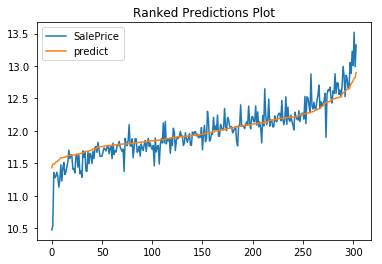

In [240]:
# initialize rf model
rf_model1 = H2ORandomForestEstimator(
    ntrees=10000,                    
    max_depth=10, 
    col_sample_rate_per_tree=0.1,
    sample_rate=0.8,
    stopping_rounds=50,
    score_each_iteration=True,
    nfolds=3,
    keep_cross_validation_predictions=True,
    seed=12345)           

# train rf model
rf_model1.train(
    x=encoded_combined_nums,
    y='SalePrice',
    training_frame=train,
    validation_frame=valid)

# print model information
print(rf_model1)

rf_preds1_val = rf_model1.predict(valid)
ranked_preds_plot('SalePrice', valid, rf_preds1_val) # valid RMSE not so hot ...
rf_preds1_test = rf_model1.predict(test)
gen_submission(rf_preds1_test) # 0.18030 public leaderboard

# Extreme Random Forest Method

### 0.18144 on kaggle public leaderboard

drf Model Build progress: |███████████████████████████████████████████████| 100%
Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1529446872170_39


ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.030487193356816076
RMSE: 0.1746058228032962
MAE: 0.1220579614247215
RMSLE: 0.013548376091316549
Mean Residual Deviance: 0.030487193356816076

ModelMetricsRegression: drf
** Reported on validation data. **

MSE: 0.03313466787683466
RMSE: 0.1820293049946482
MAE: 0.12290659933105896
RMSLE: 0.014127558905703986
Mean Residual Deviance: 0.03313466787683466

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 0.030112841517244547
RMSE: 0.1735305204200245
MAE: 0.12046731963285878
RMSLE: 0.013471527323874051
Mean Residual Deviance: 0.030112841517244547
Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid
mae,0.119631,0.0095271,0.1011976,0.1330257,0.1246697
mean_residual_deviance,0.0296397,0.0050716,0.0212616,0.0387803,0.0288772
mse,0.0296397,0.0050716,0.0212616,0.0387803,0.0288772
r2,0.7996036,0.0222865,0.8234301,0.755067,0.8203139
residual_deviance,0.0296397,0.0050716,0.0212616,0.0387803,0.0288772
rmse,0.1708912,0.0147630,0.1458136,0.1969271,0.1699329
rmsle,0.0132333,0.0012662,0.0111179,0.0154968,0.0130852


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2018-06-19 23:51:21,5.946 sec,0.0,nan,nan,nan,nan,nan,nan
,2018-06-19 23:51:21,5.974 sec,1.0,0.3124210,0.2256342,0.0976069,0.2868700,0.2144248,0.0822944
,2018-06-19 23:51:21,5.998 sec,2.0,0.3098742,0.2169412,0.0960220,0.2402412,0.1736329,0.0577158
,2018-06-19 23:51:21,6.033 sec,3.0,0.2775691,0.1971552,0.0770446,0.2143224,0.1497805,0.0459341
,2018-06-19 23:51:21,6.054 sec,4.0,0.2960683,0.2072431,0.0876564,0.2166860,0.1550492,0.0469528
---,---,---,---,---,---,---,---,---,---
,2018-06-19 23:51:26,10.388 sec,156.0,0.1753811,0.1224974,0.0307585,0.1824481,0.1234159,0.0332873
,2018-06-19 23:51:26,10.420 sec,157.0,0.1752577,0.1223097,0.0307152,0.1823753,0.1232537,0.0332608
,2018-06-19 23:51:26,10.458 sec,158.0,0.1751164,0.1223034,0.0306658,0.1822738,0.1231968,0.0332237
,2018-06-19 23:51:26,10.503 sec,159.0,0.1747965,0.1222014,0.0305538,0.1821403,0.1230729,0.0331751



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
YearBuilt,978.1448364,1.0,0.0782912
OverallQual,910.8990479,0.9312517,0.0729088
GrLivArea,679.8666992,0.6950573,0.0544168
GarageCars,669.8948975,0.6848627,0.0536187
GarageArea,549.1101685,0.5613792,0.0439510
---,---,---,---
Foundation_Stone,0.4816982,0.0004925,0.0000386
Heating_Wall,0.4034815,0.0004125,0.0000323
HouseStyle_2.5Unf,0.3394826,0.0003471,0.0000272
Condition2_Feedr,0.3349851,0.0003425,0.0000268



See the whole table with table.as_data_frame()

drf prediction progress: |████████████████████████████████████████████████| 100%


SalePrice,predict
12.4292,12.4734
11.7714,11.814
11.8776,11.8227
12.3458,12.3535
11.7745,11.8862
12.4541,12.3892
12.2429,12.0378
11.9829,11.9445
11.8776,11.9133
11.752,11.8225



drf prediction progress: |████████████████████████████████████████████████| 100%


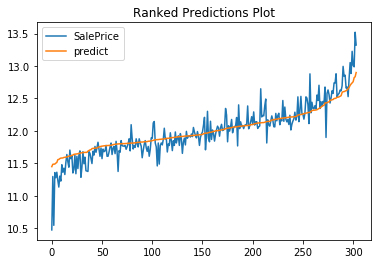

In [223]:
ert_model1 = H2ORandomForestEstimator(
    ntrees=10000,                    
    max_depth=10, 
    col_sample_rate_per_tree=0.1,
    sample_rate=0.8,
    stopping_rounds=50,
    score_each_iteration=True,
    nfolds=3,
    keep_cross_validation_predictions=True,
    seed=12345,
    histogram_type='random') # <- this is what makes it ERT instead of RF

# train ert model
ert_model1.train(
    x=encoded_combined_nums,
    y='SalePrice',
    training_frame=train,
    validation_frame=valid)

# print model information/create submission
print(ert_model1)
ert_preds1_val = ert_model1.predict(valid)
ranked_preds_plot('SalePrice', valid, ert_preds1_val) # valid RMSE not so hot ...
ert_preds1_test = ert_model1.predict(test)
gen_submission(ert_preds1_test) # 0.18144 public leaderboard

# Native XGBoost GBM 

### 0.12909 on kaggle leader board

[0]	train-rmse:0.382303	eval-rmse:0.415649
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 50 rounds.
[1]	train-rmse:0.381074	eval-rmse:0.414479
[2]	train-rmse:0.379516	eval-rmse:0.413083
[3]	train-rmse:0.378177	eval-rmse:0.411761
[4]	train-rmse:0.376726	eval-rmse:0.410213
[5]	train-rmse:0.375355	eval-rmse:0.408838
[6]	train-rmse:0.374106	eval-rmse:0.407627
[7]	train-rmse:0.372935	eval-rmse:0.406388
[8]	train-rmse:0.371491	eval-rmse:0.404989
[9]	train-rmse:0.370099	eval-rmse:0.403587
[10]	train-rmse:0.368876	eval-rmse:0.402324
[11]	train-rmse:0.36784	eval-rmse:0.401272
[12]	train-rmse:0.366633	eval-rmse:0.400178
[13]	train-rmse:0.365239	eval-rmse:0.398807
[14]	train-rmse:0.36411	eval-rmse:0.397664
[15]	train-rmse:0.362721	eval-rmse:0.396272
[16]	train-rmse:0.361685	eval-rmse:0.395138
[17]	train-rmse:0.360372	eval-rmse:0.39369
[18]	train-rmse:0.35926	eval-rmse:0.392646
[19]	train-rmse:0.358213	eval-rmse:

[183]	train-rmse:0.213543	eval-rmse:0.245275
[184]	train-rmse:0.212986	eval-rmse:0.244676
[185]	train-rmse:0.212404	eval-rmse:0.24397
[186]	train-rmse:0.211828	eval-rmse:0.243328
[187]	train-rmse:0.211177	eval-rmse:0.242649
[188]	train-rmse:0.210596	eval-rmse:0.24206
[189]	train-rmse:0.209975	eval-rmse:0.241507
[190]	train-rmse:0.209333	eval-rmse:0.240971
[191]	train-rmse:0.208784	eval-rmse:0.240458
[192]	train-rmse:0.208277	eval-rmse:0.239852
[193]	train-rmse:0.207787	eval-rmse:0.23941
[194]	train-rmse:0.207166	eval-rmse:0.238828
[195]	train-rmse:0.206694	eval-rmse:0.238444
[196]	train-rmse:0.205979	eval-rmse:0.237684
[197]	train-rmse:0.205416	eval-rmse:0.237245
[198]	train-rmse:0.204809	eval-rmse:0.236617
[199]	train-rmse:0.204342	eval-rmse:0.236188
[200]	train-rmse:0.203789	eval-rmse:0.235693
[201]	train-rmse:0.2033	eval-rmse:0.235283
[202]	train-rmse:0.202663	eval-rmse:0.234521
[203]	train-rmse:0.202095	eval-rmse:0.23395
[204]	train-rmse:0.201546	eval-rmse:0.233512
[205]	train-rmse

[367]	train-rmse:0.141242	eval-rmse:0.17476
[368]	train-rmse:0.141036	eval-rmse:0.174646
[369]	train-rmse:0.140897	eval-rmse:0.174544
[370]	train-rmse:0.140621	eval-rmse:0.174256
[371]	train-rmse:0.140327	eval-rmse:0.173928
[372]	train-rmse:0.140232	eval-rmse:0.173829
[373]	train-rmse:0.140013	eval-rmse:0.1736
[374]	train-rmse:0.13972	eval-rmse:0.173188
[375]	train-rmse:0.139399	eval-rmse:0.172919
[376]	train-rmse:0.139169	eval-rmse:0.172728
[377]	train-rmse:0.138896	eval-rmse:0.172514
[378]	train-rmse:0.138561	eval-rmse:0.172241
[379]	train-rmse:0.138433	eval-rmse:0.172195
[380]	train-rmse:0.138245	eval-rmse:0.171995
[381]	train-rmse:0.138147	eval-rmse:0.171795
[382]	train-rmse:0.137994	eval-rmse:0.171609
[383]	train-rmse:0.137801	eval-rmse:0.171427
[384]	train-rmse:0.137589	eval-rmse:0.171269
[385]	train-rmse:0.137387	eval-rmse:0.171027
[386]	train-rmse:0.13717	eval-rmse:0.170842
[387]	train-rmse:0.136918	eval-rmse:0.170688
[388]	train-rmse:0.136701	eval-rmse:0.170527
[389]	train-rms

[551]	train-rmse:0.110714	eval-rmse:0.148377
[552]	train-rmse:0.110622	eval-rmse:0.148285
[553]	train-rmse:0.110607	eval-rmse:0.148248
[554]	train-rmse:0.110523	eval-rmse:0.148178
[555]	train-rmse:0.110462	eval-rmse:0.148118
[556]	train-rmse:0.11029	eval-rmse:0.147942
[557]	train-rmse:0.110206	eval-rmse:0.147812
[558]	train-rmse:0.110165	eval-rmse:0.147772
[559]	train-rmse:0.11002	eval-rmse:0.147669
[560]	train-rmse:0.109817	eval-rmse:0.1475
[561]	train-rmse:0.109724	eval-rmse:0.14744
[562]	train-rmse:0.109608	eval-rmse:0.14733
[563]	train-rmse:0.109555	eval-rmse:0.147263
[564]	train-rmse:0.109349	eval-rmse:0.147026
[565]	train-rmse:0.109328	eval-rmse:0.147014
[566]	train-rmse:0.109264	eval-rmse:0.146965
[567]	train-rmse:0.109053	eval-rmse:0.146766
[568]	train-rmse:0.108964	eval-rmse:0.146693
[569]	train-rmse:0.10878	eval-rmse:0.146533
[570]	train-rmse:0.10865	eval-rmse:0.146444
[571]	train-rmse:0.108524	eval-rmse:0.146326
[572]	train-rmse:0.108478	eval-rmse:0.146267
[573]	train-rmse:0

[735]	train-rmse:0.09638	eval-rmse:0.137135
[736]	train-rmse:0.096333	eval-rmse:0.137121
[737]	train-rmse:0.096305	eval-rmse:0.137056
[738]	train-rmse:0.096269	eval-rmse:0.137034
[739]	train-rmse:0.096178	eval-rmse:0.136935
[740]	train-rmse:0.096178	eval-rmse:0.136887
[741]	train-rmse:0.096081	eval-rmse:0.136831
[742]	train-rmse:0.096018	eval-rmse:0.136796
[743]	train-rmse:0.095898	eval-rmse:0.136684
[744]	train-rmse:0.095935	eval-rmse:0.136634
[745]	train-rmse:0.095883	eval-rmse:0.136601
[746]	train-rmse:0.095803	eval-rmse:0.136505
[747]	train-rmse:0.095796	eval-rmse:0.136515
[748]	train-rmse:0.095773	eval-rmse:0.136491
[749]	train-rmse:0.095671	eval-rmse:0.136393
[750]	train-rmse:0.095623	eval-rmse:0.136376
[751]	train-rmse:0.095574	eval-rmse:0.136372
[752]	train-rmse:0.095548	eval-rmse:0.136319
[753]	train-rmse:0.095459	eval-rmse:0.136283
[754]	train-rmse:0.095382	eval-rmse:0.136252
[755]	train-rmse:0.095364	eval-rmse:0.136286
[756]	train-rmse:0.095303	eval-rmse:0.136222
[757]	train

[918]	train-rmse:0.088558	eval-rmse:0.131699
[919]	train-rmse:0.088552	eval-rmse:0.131704
[920]	train-rmse:0.08851	eval-rmse:0.131709
[921]	train-rmse:0.088476	eval-rmse:0.13171
[922]	train-rmse:0.08845	eval-rmse:0.131725
[923]	train-rmse:0.088417	eval-rmse:0.131709
[924]	train-rmse:0.088348	eval-rmse:0.131702
[925]	train-rmse:0.088299	eval-rmse:0.131677
[926]	train-rmse:0.088262	eval-rmse:0.131656
[927]	train-rmse:0.08822	eval-rmse:0.131631
[928]	train-rmse:0.088192	eval-rmse:0.131619
[929]	train-rmse:0.088183	eval-rmse:0.131667
[930]	train-rmse:0.088175	eval-rmse:0.131625
[931]	train-rmse:0.088152	eval-rmse:0.131644
[932]	train-rmse:0.088095	eval-rmse:0.131592
[933]	train-rmse:0.088068	eval-rmse:0.131541
[934]	train-rmse:0.088042	eval-rmse:0.13152
[935]	train-rmse:0.087994	eval-rmse:0.131471
[936]	train-rmse:0.087927	eval-rmse:0.131451
[937]	train-rmse:0.087898	eval-rmse:0.131381
[938]	train-rmse:0.087855	eval-rmse:0.13134
[939]	train-rmse:0.087817	eval-rmse:0.1313
[940]	train-rmse:0

[1099]	train-rmse:0.083153	eval-rmse:0.129709
[1100]	train-rmse:0.083139	eval-rmse:0.129684
[1101]	train-rmse:0.08311	eval-rmse:0.129691
[1102]	train-rmse:0.083091	eval-rmse:0.129685
[1103]	train-rmse:0.083057	eval-rmse:0.129693
[1104]	train-rmse:0.083045	eval-rmse:0.129713
[1105]	train-rmse:0.082999	eval-rmse:0.129704
[1106]	train-rmse:0.082958	eval-rmse:0.129667
[1107]	train-rmse:0.082943	eval-rmse:0.12966
[1108]	train-rmse:0.08289	eval-rmse:0.12963
[1109]	train-rmse:0.082877	eval-rmse:0.12962
[1110]	train-rmse:0.082863	eval-rmse:0.129623
[1111]	train-rmse:0.082825	eval-rmse:0.12957
[1112]	train-rmse:0.082801	eval-rmse:0.129514
[1113]	train-rmse:0.082796	eval-rmse:0.129527
[1114]	train-rmse:0.082784	eval-rmse:0.129538
[1115]	train-rmse:0.08274	eval-rmse:0.1295
[1116]	train-rmse:0.082728	eval-rmse:0.129509
[1117]	train-rmse:0.082692	eval-rmse:0.129468
[1118]	train-rmse:0.082669	eval-rmse:0.129486
[1119]	train-rmse:0.082679	eval-rmse:0.129507
[1120]	train-rmse:0.082654	eval-rmse:0.1294

[1279]	train-rmse:0.079022	eval-rmse:0.12874
[1280]	train-rmse:0.07901	eval-rmse:0.128729
[1281]	train-rmse:0.078993	eval-rmse:0.128732
[1282]	train-rmse:0.07899	eval-rmse:0.128731
[1283]	train-rmse:0.078966	eval-rmse:0.128712
[1284]	train-rmse:0.078915	eval-rmse:0.128735
[1285]	train-rmse:0.078889	eval-rmse:0.128665
[1286]	train-rmse:0.078877	eval-rmse:0.128671
[1287]	train-rmse:0.078859	eval-rmse:0.128637
[1288]	train-rmse:0.078814	eval-rmse:0.128637
[1289]	train-rmse:0.078811	eval-rmse:0.128615
[1290]	train-rmse:0.078785	eval-rmse:0.1286
[1291]	train-rmse:0.078783	eval-rmse:0.128582
[1292]	train-rmse:0.078762	eval-rmse:0.128582
[1293]	train-rmse:0.078751	eval-rmse:0.128582
[1294]	train-rmse:0.078727	eval-rmse:0.128598
[1295]	train-rmse:0.078692	eval-rmse:0.128591
[1296]	train-rmse:0.078663	eval-rmse:0.128552
[1297]	train-rmse:0.078619	eval-rmse:0.128551
[1298]	train-rmse:0.07858	eval-rmse:0.128556
[1299]	train-rmse:0.078567	eval-rmse:0.128542
[1300]	train-rmse:0.078573	eval-rmse:0.1

SalePrice,predict
12.4292,12.6214
11.7714,11.7897
11.8776,11.7956
12.3458,12.4229
11.7745,11.8599
12.4541,12.4865
12.2429,12.1041
11.9829,11.8792
11.8776,11.8299
11.752,11.7832



Parse progress: |█████████████████████████████████████████████████████████| 100%


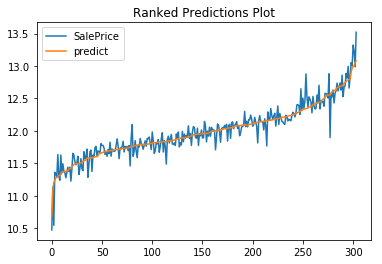

In [225]:
ave_y = train['SalePrice'].mean()[0]

# XGBoost uses SVMLight data structure, not Numpy arrays or Pandas data frames 
dtrain1 = xgb.DMatrix(train.as_data_frame()[encoded_combined_nums],
                      train.as_data_frame()['SalePrice'])
dvalid1 = xgb.DMatrix(valid.as_data_frame()[encoded_combined_nums],
                      valid.as_data_frame()['SalePrice'])
dtest = xgb.DMatrix(test.as_data_frame()[encoded_combined_nums])

# tuning parameters
params1 = {
    'objective': 'reg:linear',
    'booster': 'gbtree', 
    'eval_metric': 'rmse',
    'eta': 0.005,
    'subsample': 0.1, 
    'colsample_bytree': 0.8,
    'max_depth': 5,
    'reg_alpha' : 0.007,
    'reg_lambda' : 0.0,
    'base_score': ave_y,
    'silent': 0,
    'seed': 12345,
}

# watchlist is used for early stopping
watchlist = [(dtrain1, 'train'), (dvalid1, 'eval')]

# train model
xgb_model1 = xgb.train(params1, 
                       dtrain1, 
                       10000,
                       evals=watchlist, 
                       early_stopping_rounds=50, 
                       verbose_eval=True)

# create assessment stats and submission file
xgb_preds1_val = h2o.H2OFrame(xgb_model1.predict(dvalid1).tolist())
ranked_preds_plot('SalePrice', valid, xgb_preds1_val) 
xgb_preds1_test = h2o.H2OFrame(xgb_model1.predict(dtest).tolist())
gen_submission(xgb_preds1_test) 

# 0.12909 on kaggle leader board

# Blended Method

In [227]:
import os

def pred_blender(dir_, files):
    
    """ Performs simple blending of prediction files. 
    
    :param dir_: Directory in which files to be read are stored.
    :param files: List of prediction files to be blended.
    
    """
    
    # read predictions in files list and cbind
    for i, file in enumerate(files):
        if i == 0:
            df = pd.read_csv(dir_ + os.sep + file).drop('SalePrice', axis=1)
        col = pd.read_csv(dir_ + os.sep + file).drop('Id', axis=1)
        col.columns = ['SalePrice' + str(i)]
        df = pd.concat([df, col], axis=1)
        
    # create mean prediction    
    df['mean'] = df.iloc[:, 1:].mean(axis=1)
    print(df.head())
        
    # create time stamp
    time_stamp = re.sub('[: ]', '_', time.asctime())        
        
    # write new submission file    
    df = df[['Id', 'mean']]
    df.columns = ['Id', 'SalePrice']
    
    # save file for submission
    sub_fname = 'blended' + str(time_stamp) + '.csv'
    df.to_csv(sub_fname, index=False)

In [232]:
# create XGBoost blend

# create XGBoost blend# create  
pred_blender('',['GLM.csv','XGB.csv'])

FileNotFoundError: File b'/GLM.csv' does not exist

# Stack Method

In [233]:
from h2o.estimators.stackedensemble import H2OStackedEnsembleEstimator

In [258]:
stack = H2OStackedEnsembleEstimator(training_frame=train, 
                                    validation_frame=valid, 
                                    base_models=[h2o_gbm_model,h2o_xgb_model])

In [259]:
stack.train(x=encoded_combined_nums,
            y='SalePrice',
            training_frame=train,
            validation_frame=valid)

stackedensemble Model Build progress: |███████████████████████████████████| 100%


Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_model_python_1529446872170_47
No model summary for this model


ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 0.001597838594371187
RMSE: 0.039972973299107824
MAE: 0.029166180780446985
RMSLE: 0.0031313281990984934
R^2: 0.9891663777029499
Mean Residual Deviance: 0.001597838594371187
Null degrees of freedom: 688
Residual degrees of freedom: 686
Null deviance: 101.61982403839338
Residual deviance: 1.1009107915217478
AIC: -2473.244972446663

ModelMetricsRegressionGLM: stackedensemble
** Reported on validation data. **

MSE: 0.016754606365710835
RMSE: 0.12943958577541428
MAE: 0.09098342499271897
RMSLE: 0.009996656128203074
R^2: 0.9025375223826764
Mean Residual Deviance: 0.016754606365710835
Null degrees of freedom: 303
Residual degrees of freedom: 301
Null deviance: 52.96968362495011
Residual deviance: 5.093400335176094
AIC: -372.3663155011268

stackedensemble prediction

SalePrice,predict
12.4292,12.6297
11.7714,11.7383
11.8776,11.7932
12.3458,12.3788
11.7745,11.8495
12.4541,12.391
12.2429,12.216
11.9829,11.8078
11.8776,11.8688
11.752,11.8109



stackedensemble prediction progress: |████████████████████████████████████| 100%


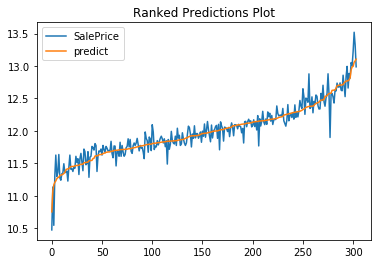

In [260]:

# print model information/create submission
print(stack)
stack_preds1_val = stack.predict(valid)
ranked_preds_plot('SalePrice', valid, stack_preds1_val) 
stack_preds1_test = stack.predict(test)
gen_submission(stack_preds1_test)

# 0.13652

# Lasso 

In [400]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb

In [407]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

In [410]:
score = rmsle_cv(lasso)

In [409]:
n_folds=3
def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)